<span style="color:blue; font-size:24px;"><b>BERTopic analysis of university complaints</b></span>

<span style="color:orange; font-size:18px;"><b>0. Loading the data</b></span>

In [30]:
import os
import sys
import pandas as pd

# Project root path
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(BASE_DIR)

DATA_PATH = os.path.join(BASE_DIR, "data", "raw", "Datasetprojpowerbi.csv")
df = pd.read_csv(DATA_PATH)

texts = df["Reports"].tolist()
print(f"Loaded {len(texts)} docs.")

Loaded 1005 docs.


<span style="color:orange; font-size:18px;"><b>1. Cleaning and tokenizing</b></span>

In [31]:
from src.preprocessing.clean_for_bert import clean_texts_bert

# 1. Normalization
cleaned_texts = clean_texts_bert(texts)

print(f"Cleaned and tokenized {len(cleaned_texts)} docs.")

Cleaned and tokenized 1005 docs.


<span style="color:orange; font-size:18px;"><b>2. Stopwords and vectorization </b></span>

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

english_stopwords = stopwords.words('english')
domain_stopwords = [    
    "make", "need", "hard", "difficult", "wish", "really", "feel", "experience",
    "get", "feel_like", "often", "student", "university", "lack", "take", "enough",
    "challenge", "limited", "important", "try", "keep", "high", "way", "always", "due", 
    "would", "afford", "would_great", "like", "able", "affordable", "different", "seem",
    "especially", "could", "frustrating", "im", "ive", "us", "seems", "shouldnt", "clearly",
    "dont", "think", "great", "even", "making", "given", "doesnt", "challenging", "anything",
    "much", "shows", "seems", "still", "near", "new", "made", "causing", "worried", "going",
    "constantly", "better", "unacceptable", "give", "one", "causing"
]

all_stopwords = english_stopwords + domain_stopwords
vectorizer = CountVectorizer(stop_words=all_stopwords)    # This is a BoW vectorizer

<span style="color:orange; font-size:18px;"><b>3. Training BERTopic model</b></span>

In [33]:
from src.topic_models.bertopic_model import train_bertopic, print_topics

bert_model, topics = train_bertopic(cleaned_texts, nr_topics=12, verbose=True, vectorizer=vectorizer)   # we set 12 topics to get 11 definined topics + "the rest" with number -1

print_topics(bert_model, top_n_words=20)

2025-11-21 18:17:55,471 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-11-21 18:17:57,890 - BERTopic - Embedding - Completed ✓
2025-11-21 18:17:57,890 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-21 18:17:58,440 - BERTopic - Dimensionality - Completed ✓
2025-11-21 18:17:58,440 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-21 18:17:58,451 - BERTopic - Cluster - Completed ✓
2025-11-21 18:17:58,452 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-21 18:17:58,467 - BERTopic - Representation - Completed ✓
2025-11-21 18:17:58,468 - BERTopic - Topic reduction - Reducing number of topics
2025-11-21 18:17:58,470 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-21 18:17:58,480 - BERTopic - Representation - Completed ✓
2025-11-21 18:17:58,481 - BERTopic - Topic reduction - Reduced number of topics from 24 to 12


Topic 0: students, international, language, cultural, sometimes, transportation, housing, campus, learn, rent, opportunities, find, public, options, love, activities, events, community, area, bus
Topic 1: financial, health, pay, medical, care, expenses, aid, mental, cost, insurance, tuition, debt, college, loan, struggling, ends, money, cover, scholarships, help
Topic 2: food, options, cafeteria, campus, offer, cantine, available, dining, hall, overpriced, quality, healthy, snacks, served, stale, coffee, vegetarian, prices, vending, machines
Topic 3: access, materials, research, databases, course, software, technology, complete, availability, accessing, academic, assignments, finding, difficulty, ability, resources, library, coursework, succeed, hindering
Topic 4: job, opportunities, internships, field, career, networking, students, internship, offer, market, available, find, professionals, jobs, connect, development, gain, despite, provide, events
Topic 5: academic, workload, time, re

<span style="color:orange; font-size:18px;"><b>4. Saving the model</b></span>

In [10]:
from src.topic_models.lsa_lda_models import save_model

os.makedirs(os.path.join(BASE_DIR, "models", "bertopic"), exist_ok=True)

save_path = os.path.join(BASE_DIR, "models", "bertopic", "bert_model_1.pkl")
save_model(bert_model, save_path)

print(f"Model is saved to {save_path}")

2025-11-21 13:49:34,865 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Model is saved to /home/dmitry/Projects/IU_claims/models/bertopic/bert_model_1.pkl


<span style="color:orange; font-size:18px;"><b>5. Topic histogram</b></span>

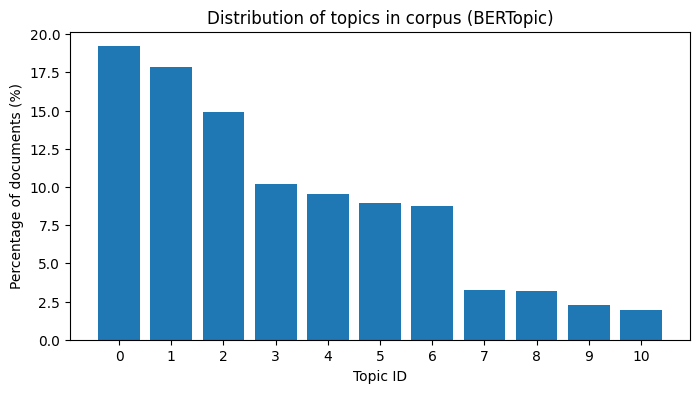

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

topic_counts = Counter(topics)

# Exclude outliers (-1)
topic_ids = [tid for tid in topic_counts if tid != -1]
counts = [topic_counts[tid] for tid in topic_ids]

# Percentage
total_docs = len([t for t in topics if t != -1])
percentages = [(c / total_docs) * 100 for c in counts]

# Histogram
plt.figure(figsize=(8,4))
plt.bar(topic_ids, percentages)
plt.xticks(topic_ids)
plt.ylabel("Percentage of documents (%)")
plt.xlabel("Topic ID")
plt.title("Distribution of topics in corpus (BERTopic)")

plt.show()

In [19]:
topic_counts

Counter({0: 187,
         1: 174,
         2: 145,
         3: 99,
         4: 93,
         5: 87,
         6: 85,
         7: 32,
         -1: 31,
         8: 31,
         9: 22,
         10: 19})

<span style="color:orange; font-size:18px;"><b>6. Topic summary done by ChatGPT based on 20 words for each topic</b></span>

<h1>Student Complaints Topic Summary (BERTopic)</h1>

<h2>Topic 0: Student Life & Campus Environment</h2>
<p>This topic covers students discussing their life on campus, including housing, transportation, events, and cultural experiences. Concerns include navigating campus facilities and finding opportunities for learning and engagement.</p>
<p class="keywords">Key words: students, international, language, cultural, transportation, campus, housing, learn, opportunities, events, class, activities</p>

<h2>Topic 1: Online Access & Course Materials</h2>
<p>This topic focuses on students' difficulties accessing online classes, course materials, databases, and software. Issues include completing assignments, using technical resources, and interacting with professors.</p>
<p class="keywords">Key words: online, access, classes, materials, research, course, databases, software, technology, resources, assignments, coursework</p>

<h2>Topic 2: Financial & Health Concerns</h2>
<p>This topic addresses financial struggles and health-related issues. Students discuss paying for tuition, medical expenses, insurance, loans, and the challenges of mental health and financial aid.</p>
<p class="keywords">Key words: financial, health, medical, pay, care, expenses, aid, mental, cost, insurance, tuition, debt, loan, scholarships, help</p>

<h2>Topic 3: Food & Cafeteria Experience</h2>
<p>This topic relates to food options on campus, cafeteria quality, pricing, availability, and student satisfaction. Complaints include stale or overpriced food and limited healthy options.</p>
<p class="keywords">Key words: options, campus, food, cafeteria, cantine, offer, available, quality, stale, snacks, coffee, dining</p>

<h2>Topic 4: Jobs & Career Opportunities</h2>
<p>This topic concerns career development, internships, networking, and job opportunities. Students discuss how to connect with professionals, find internships, and develop career-related skills.</p>
<p class="keywords">Key words: job, opportunities, internships, field, career, networking, students, offer, internship, market, professionals, connect</p>

<h2>Topic 5: Academic Workload & Stress</h2>
<p>This topic addresses academic workload, time management, and the stress associated with balancing work, commitments, and mental health. Students describe feeling overwhelmed and struggling to manage responsibilities.</p>
<p class="keywords">Key words: academic, workload, time, responsibilities, work, commitments, stress, anxiety, mental, health, balance, sleep, managing, struggling</p>

<h2>Topic 6: Sports & Athletics</h2>
<p>This topic focuses on athletic programs, eligibility, facilities, and support for student-athletes. Discussions include gender inequality, team requirements, and sports-related resources and compliance.</p>
<p class="keywords">Key words: sports, athletic, athletes, gender, eligibility, needs, programs, team, facilities, requirements, support, resources, injuries</p>

<h2>Topic 7: Courses & Grading</h2>
<p>This topic deals with course expectations, understanding material, grading concerns, and student experiences with professors. Students discuss challenges in learning and navigating academic standards.</p>
<p class="keywords">Key words: course, professor, material, understand, expected, grading, grade, class, struggling, learning, teaching, education, textbook, success</p>

<h2>Topic 8: Administrative Affairs & Certificates</h2>
<p>This topic covers administrative processes, certificates, applications, and student interactions with offices. Concerns include delays, managing multiple requests, and communication with staff.</p>
<p class="keywords">Key words: affairs, office, certificate, certificates, needs, processed, application, processes, birth, military, training, requests, communication, students</p>

<h2>Topic 9: Food Hall Complaints</h2>
<p>This topic addresses issues in dining halls, including food quality, service, hygiene, and student dissatisfaction. Reports include incidents with stolen items, insects, or rude service.</p>
<p class="keywords">Key words: food, unable, hall, dining, cooked, liking, find, served, available, rudely, stolen, insects, harassed, appealed, charged, assaulted, sick, rodents</p>

<h2>Topic 10: Academic Advising & Career Guidance</h2>
<p>This topic concerns academic advisors, access to guidance, career planning, and support services. Students discuss difficulties receiving help, making decisions, and pursuing academic or career goals.</p>
<p class="keywords">Key words: advisors, academic, access, plan, support, careers, guidance, degree, guide, succeed, questions, receiving, career, help, program, decisions</p>

</body>
</html>
